# Network Behavior Anomaly Detection - POC

## Overview

This notebook demonstrates a proof-of-concept for detecting anomalous network behavior patterns using an autoencoder.

## Approach

We create dummy normal days data. 9-5 workhours, 6-12 evening chill hours, moives, music, 12-9 sleep
Create a matrix of 24 hours x 5 apps = 120 features.
Define an autoencoder as 120-60-30-10-30-60-120. Train it using 3-4 normal days data. Then we create test normal and anomalous day to check our autoencoder. We need to define a threshold and based on that it will mark anomalous days.



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Set random seed for reproducibility
np.random.seed(42)

In [32]:
# Define your 5 apps
apps = ['Chrome', 'Slack', 'Zoom', 'Music', 'Safari']

def create_work_day(day_variation=0.2):
    day = []

    # Hours 0-8: Sleep time (minimal usage, occasional background apps)
    for hour in range(9):
        # Sometimes Chrome might sync, or Music might be downloading
        chrome = np.random.randint(0, 20) if np.random.random() > 0.8 else 0
        day.append([chrome, 0, 0, 0, 0])

    # Hours 9-17: Work time (9 hours) - but with variations
    for hour in range(9):
        # Base work pattern with variation
        chrome_base = 300
        slack_base = 50
        zoom_base = 80 if hour in [1, 3, 6] else 20  # Meetings at certain hours

        # Add random variation
        chrome = chrome_base + np.random.randint(-100, 100)
        slack = slack_base + np.random.randint(-20, 30)
        zoom = zoom_base + np.random.randint(-20, 50)
        music = np.random.randint(0, 50) if np.random.random() > 0.7 else 0  # Occasional music
        safari = np.random.randint(0, 100) if np.random.random() > 0.6 else 0  # Sometimes use Safari

        day.append([max(0, chrome), max(0, slack), max(0, zoom), max(0, music), max(0, safari)])

    # Hours 18-23: Evening time (6 hours) - entertainment with variation
    for hour in range(6):
        # High Chrome for streaming, but varies by hour
        chrome_base = 1200 if hour < 4 else 600  # Less streaming before bed
        music_base = 200 if hour < 3 else 100    # Less music later

        chrome = chrome_base + np.random.randint(-300, 400)
        slack = np.random.randint(0, 20) if np.random.random() > 0.8 else 0  # Rare evening Slack
        zoom = np.random.randint(0, 100) if np.random.random() > 0.9 else 0  # Rare evening calls
        music = music_base + np.random.randint(-50, 100)
        safari = np.random.randint(0, 200) if np.random.random() > 0.5 else 0

        day.append([max(0, chrome), max(0, slack), max(0, zoom), max(0, music), max(0, safari)])

    return np.array(day)

# Create 3 different work days with variations
day_1 = create_work_day()
day_2 = create_work_day()
day_3 = create_work_day()
day_4 = create_work_day()
day_5 = create_work_day()
day_6 = create_work_day()

print(f"Day 1 {day_1}")
print(f"Day 2 {day_2}")
print(f"Day 3 {day_3}")
print(f"Day 4 {day_4}")
print(f"Day 5 {day_5}")
print(f"Day 6 {day_6}")

Day 1 [[  10    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [  14    0    0    0    0]
 [ 282   38   20    0    0]
 [ 314   36   75    0    0]
 [ 302   69   16    0    0]
 [ 251   65   97    0    0]
 [ 315   64    6    0    0]
 [ 398   66    4    0    0]
 [ 348   67   80   38   12]
 [ 380   47   44    0    0]
 [ 387   40   62    0    0]
 [1528    0    0  201    0]
 [1493    0    0  191  140]
 [1524   16    0  278   47]
 [ 928    0   59   70   33]
 [ 499    0    0  136   68]
 [ 715    4    0  136  108]]
Day 2 [[   2    0    0    0    0]
 [   0    0    0    0    0]
 [   7    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [ 385   34    4    0   63]
 [ 337   67   67   24   78]
 [ 377 

In [40]:
# Flatten each day into a single vector (24 hours × 5 apps = 120 features)
def flatten_day(day_data):
    return day_data.flatten()

# Prepare training data
train_days = [day_1, day_2, day_3, day_4, day_5, day_6]
X_train = np.array([flatten_day(day) for day in train_days])

print(f"Training data shape: {X_train.shape}")

# BETTER NORMALIZATION: Just scale by maximum value to keep everything 0-1
# This preserves the relative patterns within each day
max_value = X_train.max()
X_train_scaled = X_train / max_value

print(f"Max value in dataset: {max_value}")
print(f"Sample before scaling: {X_train[0][100:]}")
print(f"Sample after scaling: {X_train_scaled[0][100:]}")

Training data shape: (6, 120)
Max value in dataset: 1558
Sample before scaling: [1524   16    0  278   47  928    0   59   70   33  499    0    0  136
   68  715    4    0  136  108]
Sample after scaling: [0.97817715 0.01026958 0.         0.17843389 0.03016688 0.59563543
 0.         0.03786906 0.0449294  0.021181   0.32028241 0.
 0.         0.0872914  0.0436457  0.45892169 0.00256739 0.
 0.0872914  0.06931964]


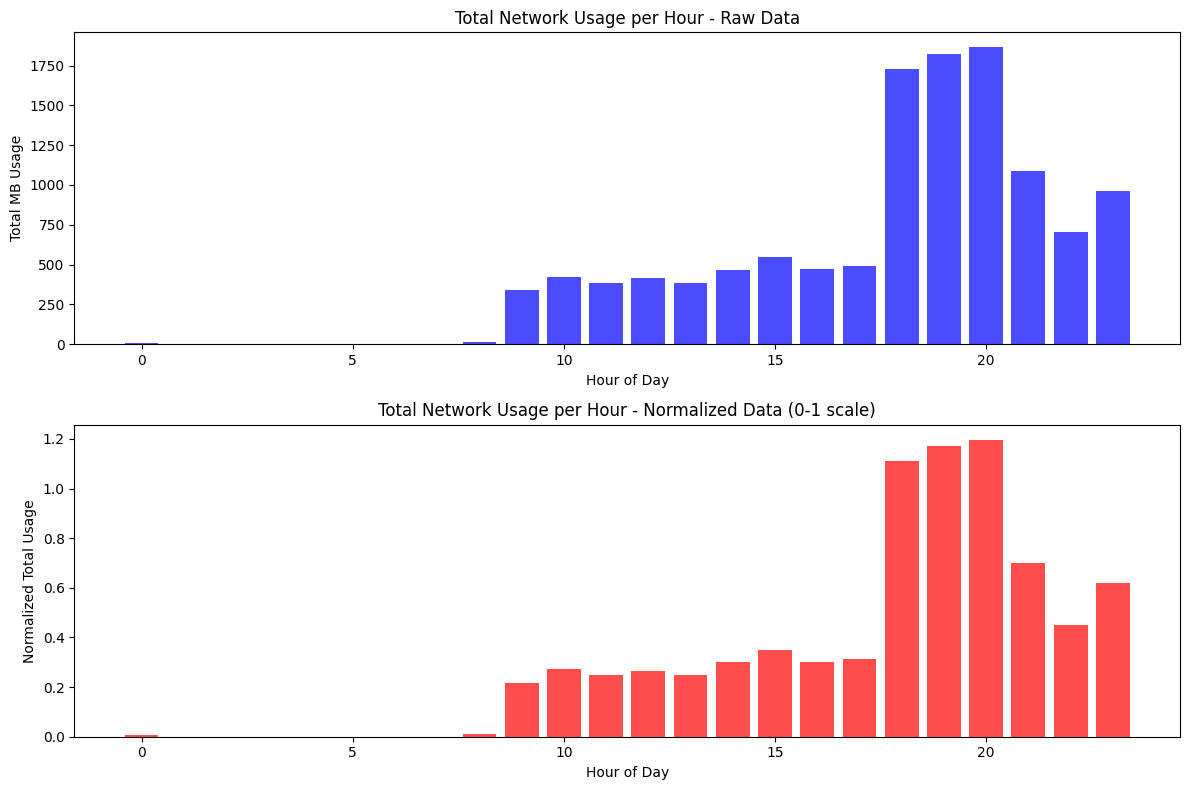

Now the shapes should be IDENTICAL!
Raw evening peak: 1865
Normalized evening peak: 1.197


In [41]:
# Reshape Day 1 back to 24 hours x 5 apps
day_1_hourly = X_train[0].reshape(24, 5)
day_1_scaled_hourly = X_train_scaled[0].reshape(24, 5)

# Calculate total usage per hour
hourly_totals_raw = day_1_hourly.sum(axis=1)
hourly_totals_scaled = day_1_scaled_hourly.sum(axis=1)

hours = range(24)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Raw hourly totals
axes[0].bar(hours, hourly_totals_raw, alpha=0.7, color='blue')
axes[0].set_title('Total Network Usage per Hour - Raw Data')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Total MB Usage')

# Plot 2: Normalized hourly totals (should look identical in shape!)
axes[1].bar(hours, hourly_totals_scaled, alpha=0.7, color='red')
axes[1].set_title('Total Network Usage per Hour - Normalized Data (0-1 scale)')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Normalized Total Usage')

plt.tight_layout()
plt.show()

print("Now the shapes should be IDENTICAL!")
print(f"Raw evening peak: {hourly_totals_raw[20]:.0f}")
print(f"Normalized evening peak: {hourly_totals_scaled[20]:.3f}")

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the autoencoder
def create_autoencoder(input_dim):
    model = Sequential([
        # Encoder: Compress 120 features down to smaller representation
        Dense(60, activation='relu', input_shape=(input_dim,)),
        Dense(30, activation='relu'),
        Dense(10, activation='relu'),  # Bottleneck layer - forces compression

        # Decoder: Reconstruct back to 120 features
        Dense(30, activation='relu'),
        Dense(60, activation='relu'),
        Dense(input_dim, activation='linear')  # Output same size as input
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

# Create the autoencoder
autoencoder = create_autoencoder(120)
autoencoder.summary()

print("Architecture explanation:")
print("Input: 120 features → 60 → 30 → 10 → 30 → 60 → 120 features")
print("The model learns to compress your daily pattern into just 10 numbers!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 60)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 120)            │         7,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,910 (73.87 KB)

 Trainable params: 18,910 (73.87 KB)

 Non-trainable params: 0 (0.00 B)

Architecture explanation:
Input: 120 features → 60 → 30 → 10 → 30 → 60 → 120 features
The model learns to compress your daily pattern into just 10 numbers!


Training autoencoder...
Epoch 1/100
6/6 - 0s - 8ms/step - loss: 2.2583e-04
Epoch 2/100
6/6 - 0s - 10ms/step - loss: 2.3259e-04
Epoch 3/100
6/6 - 0s - 8ms/step - loss: 2.1982e-04
Epoch 4/100
6/6 - 0s - 10ms/step - loss: 2.3358e-04
Epoch 5/100
6/6 - 0s - 9ms/step - loss: 2.2546e-04
Epoch 6/100
6/6 - 0s - 24ms/step - loss: 2.2510e-04
Epoch 7/100
6/6 - 0s - 12ms/step - loss: 2.2068e-04
Epoch 8/100
6/6 - 0s - 21ms/step - loss: 2.2776e-04
Epoch 9/100
6/6 - 0s - 10ms/step - loss: 2.1164e-04
Epoch 10/100
6/6 - 0s - 10ms/step - loss: 2.1422e-04
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 2.1065e-04
Epoch 12/100
6/6 - 0s - 10ms/step - loss: 2.0524e-04
Epoch 13/100
6/6 - 0s - 8ms/step - loss: 1.9057e-04
Epoch 14/100
6/6 - 0s - 10ms/step - loss: 1.9498e-04
Epoch 15/100
6/6 - 0s - 12ms/step - loss: 1.8234e-04
Epoch 16/100
6/6 - 0s - 13ms/step - loss: 1.8556e-04
Epoch 17/100
6/6 - 0s - 23ms/step - loss: 1.8660e-04
Epoch 18/100
6/6 - 0s - 22ms/step - loss: 1.7634e-04
Epoch 19/100
6/6 - 0s - 24ms/step -

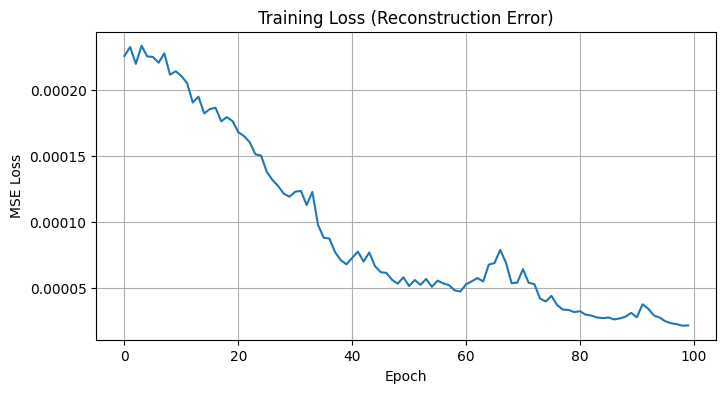

Training complete!


In [52]:
# Train the autoencoder (it tries to reconstruct the input)
print("Training autoencoder...")
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  # Input = Output (reconstruction task)
    epochs=100,
    batch_size=1,  # Small batch since we only have 3 days
    verbose=2,
    validation_split=0.0  # No validation since we have so little data
)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.title('Training Loss (Reconstruction Error)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

print("Training complete!")

In [ ]:
# Create a normal test day (similar to training days)
def create_normal_test_day():
    day = []

    # Hours 0-8: Sleep
    for hour in range(9):
        day.append([0, 0, 0, 0, 0])

    # Hours 9-17: Normal work pattern (similar to training)
    for hour in range(9):
        chrome = 280 + np.random.randint(-50, 50)
        slack = 45 + np.random.randint(-10, 15)
        zoom = 70 + np.random.randint(-20, 30)
        day.append([chrome, slack, zoom, 0, 0])

    # Hours 18-23: Normal evening
    for hour in range(6):
        chrome = 1100 + np.random.randint(-200, 300)
        music = 180 + np.random.randint(-50, 80)
        day.append([chrome, 0, 0, music, 0])

    return np.array(day)

# Create anomalous days
def create_anomaly_day_1():
    """Anomaly: Watching movies during work hours"""
    day = []

    # Hours 0-8: Sleep (normal)
    for hour in range(9):
        day.append([0, 0, 0, 0, 0])

    # Hours 9-17: ANOMALY - High entertainment during work
    for hour in range(9):
        chrome = 1200 + np.random.randint(-200, 300)  # High streaming
        music = 200 + np.random.randint(-50, 100)      # Music during work
        slack = 20 if np.random.random() > 0.7 else 0  # Minimal work
        day.append([chrome, slack, 0, music, 0])

    # Hours 18-23: Normal evening
    for hour in range(6):
        day.append([800, 0, 0, 150, 0])

    return np.array(day)

def create_anomaly_day_2():
    """Anomaly: Working late at night"""
    day = []

    # Hours 0-8: Sleep (normal)
    for hour in range(9):
        day.append([0, 0, 0, 0, 0])

    # Hours 9-17: Minimal work activity
    for hour in range(9):
        day.append([100, 10, 0, 0, 0])

    # Hours 18-23: ANOMALY - Heavy work at night
    for hour in range(6):
        chrome = 400 + np.random.randint(-50, 100)
        slack = 60 + np.random.randint(-10, 20)
        zoom = 100 + np.random.randint(-20, 50)
        day.append([chrome, slack, zoom, 0, 0])

    return np.array(day)

# Create test days
normal_test = create_normal_test_day()
anomaly_1 = create_anomaly_day_1()  # Movies during work
anomaly_2 = create_anomaly_day_2()  # Work at night

print("Test days created!")
print("Normal test day work hours (9-12):")
print(normal_test)
print("\nAnomaly 1 work hours (9-12) - should show high Chrome/Music:")
print(anomaly_1)
print("\nAnomaly 2 evening hours (18-21) - should show work apps:")
print(anomaly_2)

Test days created!
Normal test day work hours (9-12):
[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [ 325   47   79    0    0]
 [ 316   53   68    0    0]
 [ 291   51   94    0    0]
 [ 322   50   89    0    0]
 [ 248   52   50    0    0]
 [ 307   53   96    0    0]
 [ 295   56   77    0    0]
 [ 323   40   53    0    0]
 [ 230   42   78    0    0]
 [ 954    0    0  232    0]
 [1030    0    0  161    0]
 [1165    0    0  239    0]
 [1061    0    0  253    0]
 [1380    0    0  216    0]
 [ 954    0    0  161    0]]

Anomaly 1 work hours (9-12) - should show high Chrome/Music:
[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    

In [ ]:
# Prepare test data (normalize same way as training)
test_days = [normal_test, anomaly_1, anomaly_2]
test_names = ["Normal Day", "Anomaly 1 (Movies at Work)", "Anomaly 2 (Work at Night)"]

X_test = np.array([flatten_day(day) for day in test_days])
X_test_scaled = X_test / max_value  # Use same scaling as training

# Get reconstruction errors
reconstructions = autoencoder.predict(X_test_scaled)
reconstruction_errors = np.mean((X_test_scaled - reconstructions)**2, axis=1)

print("Reconstruction Errors:")
for i, (name, error) in enumerate(zip(test_names, reconstruction_errors)):
    print(f"{name}: {error:.6f}")

# Set threshold (based on training data errors)
train_reconstructions = autoencoder.predict(X_train_scaled)
train_errors = np.mean((X_train_scaled - train_reconstructions)**2, axis=1)
threshold = np.max(train_errors) * 2  # 2x worst training error

print(f"\nTraining errors: {train_errors}")
print(f"Threshold: {threshold:.6f}")

# Classify as normal or anomaly
print("\nClassification Results:")
for name, error in zip(test_names, reconstruction_errors):
    status = "ANOMALY" if error > threshold else "NORMAL"
    print(f"{name}: {status} (error: {error:.6f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Reconstruction Errors:
Normal Day: 0.002934
Anomaly 1 (Movies at Work): 0.034436
Anomaly 2 (Work at Night): 0.000933
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Training errors: [0.00061933 0.00027658 0.00089547]
Threshold: 0.001791

Classification Results:
Normal Day: ANOMALY (error: 0.002934)
Anomaly 1 (Movies at Work): ANOMALY (error: 0.034436)
Anomaly 2 (Work at Night): NORMAL (error: 0.000933)


In [ ]:
# Let's analyze this more carefully

# 1. Check what the autoencoder actually learned
print("=== TRAINING DATA ANALYSIS ===")
for i in range(3):
    print(f"Training Day {i+1} error: {train_errors[i]:.6f}")

# 2. Better threshold setting
# Use mean + 2*std of training errors instead of max*2
train_mean = np.mean(train_errors)
train_std = np.std(train_errors)
new_threshold = train_mean + 3 * train_std  # More reasonable threshold

print(f"\nTraining error mean: {train_mean:.6f}")
print(f"Training error std: {train_std:.6f}")
print(f"New threshold (mean + 3*std): {new_threshold:.6f}")

# 3. Let's also check WHY Anomaly 2 has low error
# Compare actual patterns
print("\n=== PATTERN COMPARISON ===")

# Look at evening hours for training vs anomaly 2
train_day1_evening = X_train_scaled[0].reshape(24, 5)[18:24]  # Hours 18-23
anomaly2_evening = X_test_scaled[2].reshape(24, 5)[18:24]

print("Training Day 1 evening pattern (Chrome, Slack, Zoom, Music, Safari):")
print(train_day1_evening)
print("\nAnomaly 2 evening pattern:")
print(anomaly2_evening)

# New classification with better threshold
print("\n=== REVISED CLASSIFICATION ===")
for name, error in zip(test_names, reconstruction_errors):
    status = "ANOMALY" if error > new_threshold else "NORMAL"
    print(f"{name}: {status} (error: {error:.6f})")

=== TRAINING DATA ANALYSIS ===
Training Day 1 error: 0.000619
Training Day 2 error: 0.000277
Training Day 3 error: 0.000895

Training error mean: 0.000597
Training error std: 0.000253
New threshold (mean + 3*std): 0.001357

=== PATTERN COMPARISON ===
Training Day 1 evening pattern (Chrome, Slack, Zoom, Music, Safari):
[[0.87475665 0.         0.         0.15639195 0.        ]
 [0.94094744 0.         0.         0.17326411 0.03179753]
 [0.75730045 0.00713822 0.         0.13367943 0.02985075]
 [0.71771577 0.         0.         0.08046723 0.        ]
 [0.467878   0.         0.03179753 0.0953926  0.05061648]
 [0.47631408 0.01232966 0.         0.08306295 0.        ]]

Anomaly 2 evening pattern:
[[0.2816353  0.04412719 0.06359507 0.         0.        ]
 [0.24983777 0.05061648 0.09020117 0.         0.        ]
 [0.27968851 0.03309539 0.05191434 0.         0.        ]
 [0.25697599 0.03504218 0.064244   0.         0.        ]
 [0.23361454 0.03828683 0.05256327 0.         0.        ]
 [0.3036989  

In [54]:
# Let's create a test day that's MORE similar to training
def create_better_normal_test():
    # Just take training day 1 and add tiny variations
    base_day = day_1.copy()

    # Add small random noise using normal distribution instead
    for hour in range(24):
        for app in range(5):
            if base_day[hour, app] > 0:
                # Add ±10% noise using normal distribution
                noise = np.random.normal(0, base_day[hour, app] * 0.1)
                base_day[hour, app] = max(0, int(base_day[hour, app] + noise))

    return base_day

# Create more obvious anomaly
def create_obvious_anomaly():
    """Completely different pattern - high usage at wrong times"""
    day = []

    # Hours 0-8: HIGH usage during sleep (obvious anomaly)
    for hour in range(9):
        day.append([800, 100, 150, 300, 200])

    # Hours 9-23: Low usage during day (opposite of normal)
    for hour in range(15):
        day.append([50, 10, 0, 20, 10])

    return np.array(day)

# Test with better data
better_normal = create_better_normal_test()
obvious_anomaly = create_obvious_anomaly()

# Test these
new_test_days = [better_normal, anomaly_1, obvious_anomaly]
new_test_names = ["Better Normal", "Movies at Work", "Obvious Anomaly"]

print(f"Better normal day {better_normal}")
print(f"Obvious anomaly day {obvious_anomaly}")

X_new_test = np.array([flatten_day(day) for day in new_test_days])
X_new_test_scaled = X_new_test / max_value

new_reconstructions = autoencoder.predict(X_new_test_scaled)
new_errors = np.mean((X_new_test_scaled - new_reconstructions)**2, axis=1)

print("NEW TEST RESULTS:")
for name, error in zip(new_test_names, new_errors):
    status = "ANOMALY" if error > new_threshold else "NORMAL"
    print(f"{name}: {status} (error: {error:.6f})")

print(f"\nThreshold: {new_threshold:.6f}")

Better normal day [[   7    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [  15    0    0    0    0]
 [ 348   39   20    0    0]
 [ 304   29   64    0    0]
 [ 292   65   15    0    0]
 [ 271   61  105    0    0]
 [ 296   70    6    0    0]
 [ 380   66    3    0    0]
 [ 351   72   79   36   10]
 [ 402   48   38    0    0]
 [ 419   35   68    0    0]
 [1633    0    0  209    0]
 [1436    0    0  201  155]
 [1614   14    0  285   52]
 [1132    0   57   76   36]
 [ 458    0    0  160   60]
 [ 772    4    0  136  135]]
Obvious anomaly day [[800 100 150 300 200]
 [800 100 150 300 200]
 [800 100 150 300 200]
 [800 100 150 300 200]
 [800 100 150 300 200]
 [800 100 150 300 200]
 [800 100 150 300 200]
 [800 100 150 300 200]
 [800 100 150 300 200]
 [ 50  10   0  20  10]
 [ 50  10   0  20  10]
 [ 50  10   0  20  10]
 [ 50  10   0